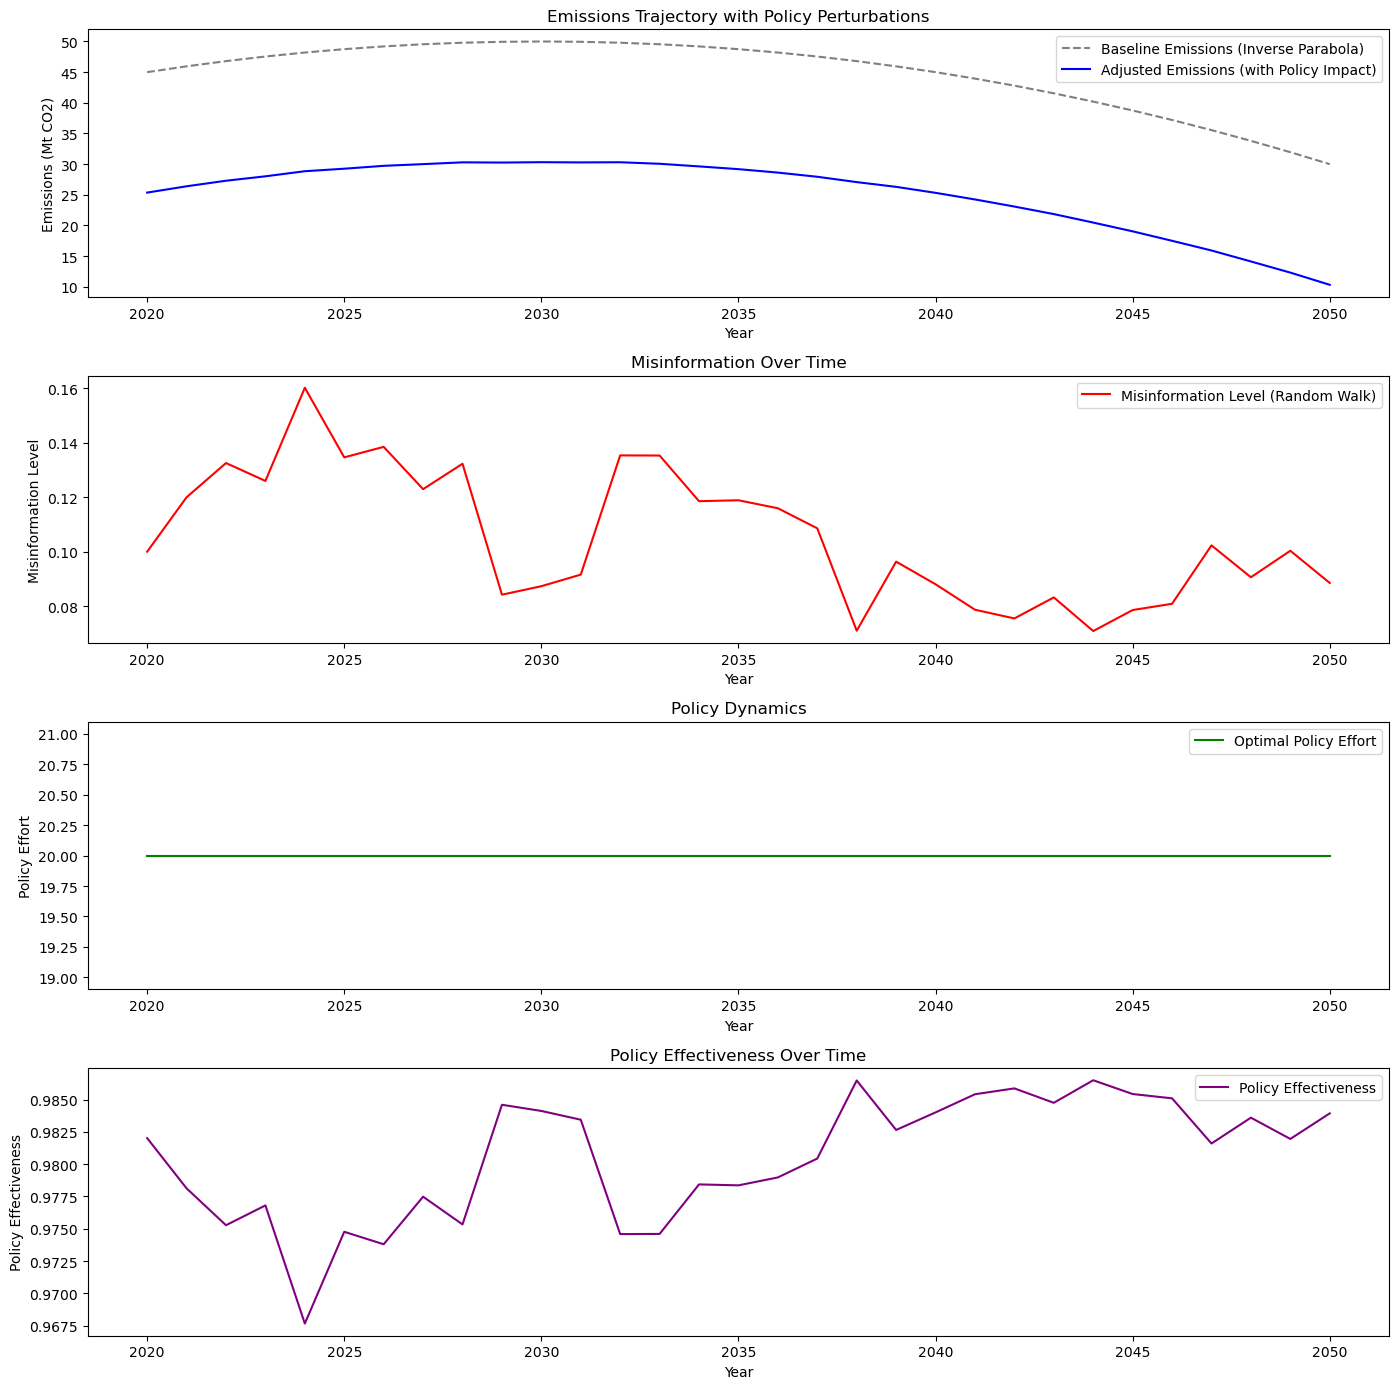

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the time horizon
years = np.arange(2020, 2051)

# Smooth inverse parabolic emissions function peaking in 2030
def emissions(years, a=0.05, b=50, peak_year=2030):
    emissions = -a * (years - peak_year) ** 2 + b
    emissions = np.clip(emissions, 0, None)  # Ensure emissions are non-negative
    return emissions

# Random walk for misinformation
def random_walk(years, initial=0.1, mu=0, sigma=0.02):
    misinformation = np.zeros_like(years, dtype=float)
    misinformation[0] = initial
    for i in range(1, len(years)):
        misinformation[i] = max(0, misinformation[i-1] + np.random.normal(mu, sigma))
    return misinformation

# Nonlinear policy effectiveness function (logistic)
def policy_effectiveness(misinformation, alpha=10, beta=0.5):
    return 1 / (1 + np.exp(alpha * (misinformation - beta)))

# Cost function (nonlinear), more expensive with high misinformation
def policy_cost(policy, misinformation, cost_factor=1.0):
    base_cost = 0.1 * policy**2
    misinformation_cost = cost_factor * (1 + misinformation) * policy  # Cost grows with misinformation
    return base_cost + misinformation_cost

# Objective function
def objective(policy, years, emissions, misinformation):
    total_cost = 0

    # Initialize the emissions affected by policy
    adjusted_emissions = emissions.copy()

    for t in range(len(years)):
        # Calculate policy effectiveness
        policy_eff = policy_effectiveness(misinformation[t])
        
        # Update emissions based on policy effectiveness
        adjusted_emissions[t] -= policy[t] * policy_eff

        # Ensure emissions are non-negative
        adjusted_emissions[t] = max(0, adjusted_emissions[t])
        
        # Calculate cost of implementing policies considering misinformation
        total_cost += adjusted_emissions[t]**2 + policy_cost(policy[t], misinformation[t])

    return total_cost

# Generate initial data
baseline_emissions = emissions(years)
misinformation_trajectory = random_walk(years, initial=0.1, mu=0, sigma=0.02)

# Initial guess for policy effort (uniform)
initial_policy = np.ones(len(years)) * 5

# Bounds on policy effort (e.g., between 0 and 20 units)
bounds = [(0, 20) for _ in years]

# Optimization
result = minimize(
    objective,
    initial_policy,
    bounds=bounds,
    args=(years, baseline_emissions, misinformation_trajectory),
    method='L-BFGS-B'
)

# Optimal policy and resulting emissions
optimal_policy = result.x
optimal_emissions = baseline_emissions.copy()
policy_effectiveness_trajectory = np.zeros(len(years))

for t in range(len(years)):
    # Update policy effectiveness
    policy_eff = policy_effectiveness(misinformation_trajectory[t])
    policy_effectiveness_trajectory[t] = policy_eff
    
    # Update emissions based on policy
    optimal_emissions[t] -= optimal_policy[t] * policy_eff

    # Ensure emissions are non-negative
    optimal_emissions[t] = max(0, optimal_emissions[t])

# Plot results
plt.figure(figsize=(14, 14))

# Plot baseline emissions and adjusted emissions
plt.subplot(4, 1, 1)
plt.plot(years, baseline_emissions, label="Baseline Emissions (Inverse Parabola)", linestyle="--", color="gray")
plt.plot(years, optimal_emissions, label="Adjusted Emissions (with Policy Impact)", color="blue")
plt.xlabel("Year")
plt.ylabel("Emissions (Mt CO2)")
plt.title("Emissions Trajectory with Policy Perturbations")
plt.legend()

# Plot misinformation
plt.subplot(4, 1, 2)
plt.plot(years, misinformation_trajectory, label="Misinformation Level (Random Walk)", color="red")
plt.xlabel("Year")
plt.ylabel("Misinformation Level")
plt.title("Misinformation Over Time")
plt.legend()

# Plot policy effort
plt.subplot(4, 1, 3)
plt.plot(years, optimal_policy, label="Optimal Policy Effort", color="green")
plt.xlabel("Year")
plt.ylabel("Policy Effort")
plt.title("Policy Dynamics")
plt.legend()

# Plot policy effectiveness
plt.subplot(4, 1, 4)
plt.plot(years, policy_effectiveness_trajectory, label="Policy Effectiveness", color="purple")
plt.xlabel("Year")
plt.ylabel("Policy Effectiveness")
plt.title("Policy Effectiveness Over Time")
plt.legend()

plt.tight_layout()
plt.show()
